In [1]:
%matplotlib nbagg
%pylab

Using matplotlib backend: nbAgg
Populating the interactive namespace from numpy and matplotlib


In [2]:
from datetime import datetime
import download
docs = []
for op, data in download.cache.iteritems():
    if op.station_id != '571e079bc76c49177837cd9b': continue
    if data is None: continue
    for row in data['rows']:
        row_data = row['c']
        
        hour_data = row_data[0]['v']
        if ' ' in hour_data: hour_data = hour_data.split()[1]
        hour = int(hour_data.split(':')[0])
        
        temp = row_data[1]['v']
        
        docs.append({
            'date': datetime(op.year, op.month, op.day, hour),
            'temp': temp,
        })

import pandas as pd
df = pd.DataFrame(docs).set_index('date', drop=False)

In [3]:
def duplicate(s):
    i = s.index.append(s.index + 24)
    v = np.hstack([s.values, s.values])
    return pd.Series(v, index=i)

<IPython.core.display.Javascript object>


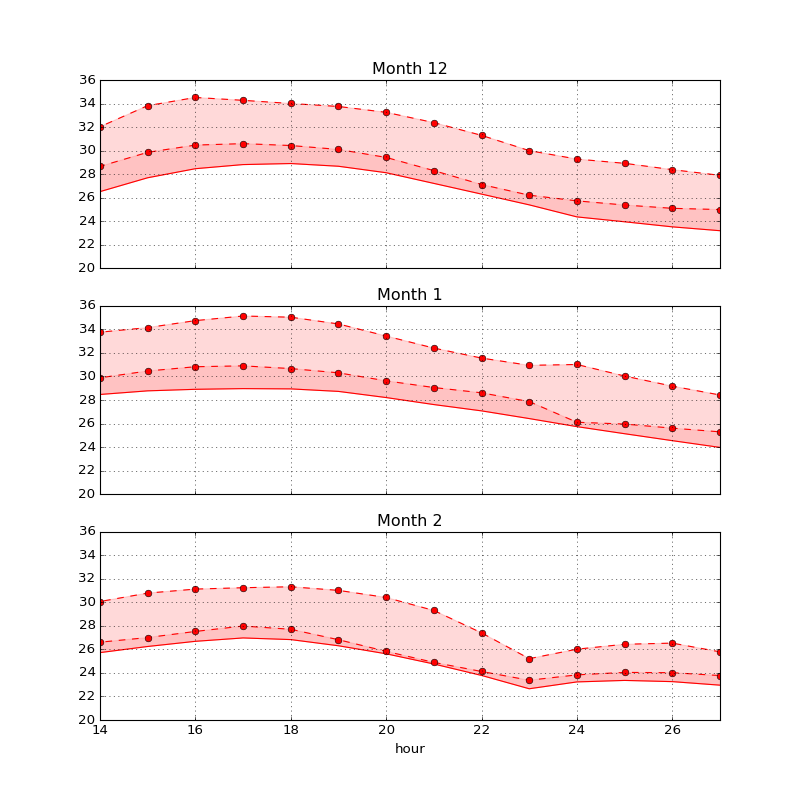

In [6]:
from statsmodels.tsa.filters.hp_filter import hpfilter

g = df.groupby(lambda x:x.month).temp

close('all')
months = [12, 1, 2]
percentiles = [63, 90]
lambd = 1

_, axs = subplots(len(months), sharey=True, sharex=True, figsize=(10, 10))
for i, month in enumerate(months):

    month_data = g.get_group(month)
    month_group = month_data.groupby(lambda x:x.hour)
    month_docs = []
    for hour, timestamps in month_group.groups.iteritems():
        hour_vals = month_data[timestamps]
        doc = {'hour': hour, 'mean': hour_vals.mean(), 'cnt': len(timestamps)}
        percentiles_values = np.percentile(hour_vals, percentiles)
        doc.update(dict(zip(percentiles, percentiles_values)))
        month_docs.append(doc)
        
    mdf = pd.DataFrame(month_docs).set_index('hour')
    month_mean = duplicate(hpfilter(mdf['mean'], lambd)[1])
    month_mean.plot(color='r', ax=axs[i])
    for p in percentiles:
        p_vals = duplicate(hpfilter(mdf[p], lambd)[1])
        axs[i].fill_between(month_mean.index, month_mean, p_vals, color='r', alpha=float(p)/600)
        p_vals.plot(color='r', style='--o', lw=1, ax=axs[i])


    axs[i].set_title('Month {}'.format(month))
    axs[i].grid()
#     axs[i].set_xticks(range(0, 48, 2), map(str, range(0, 24, 2) * 2))
    axs[i].set_xlim(14, 27)



<IPython.core.display.Javascript object>


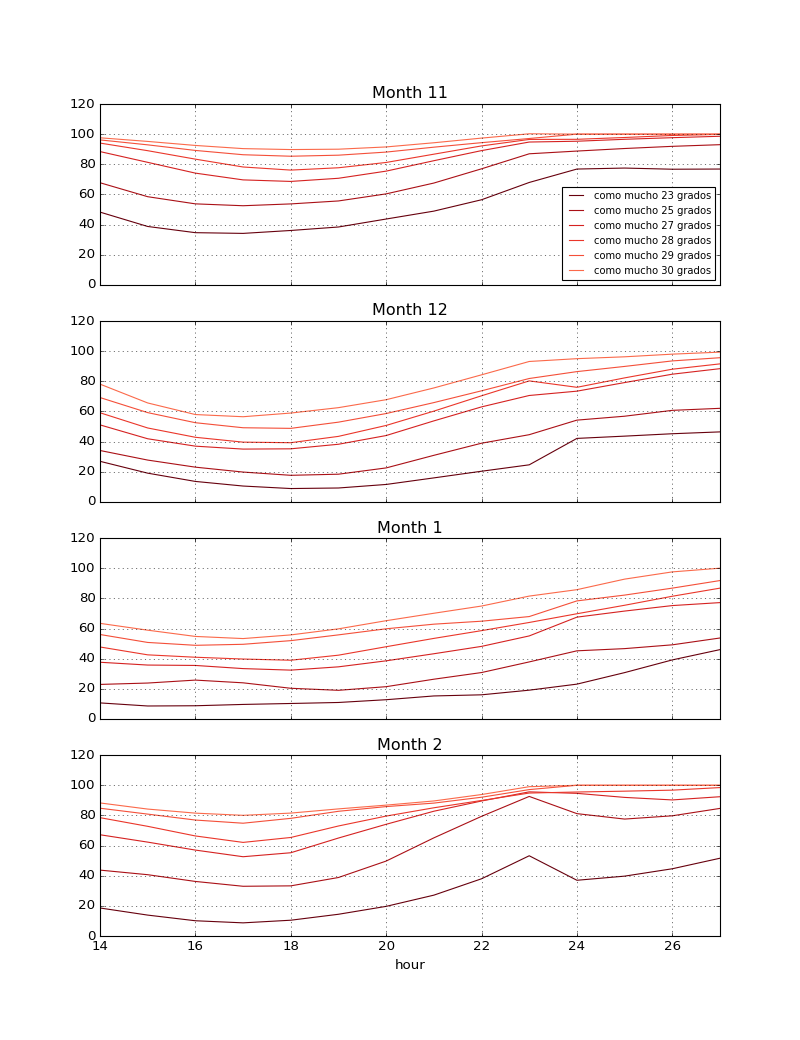

In [94]:
from statsmodels.tsa.filters.hp_filter import hpfilter

target_temperatures = [23, 25] + range(27, 31)

g = df.groupby(lambda x:x.month).temp

close('all')
months = [11, 12, 1, 2]
lambd = 1

_, axs = subplots(len(months), sharey=True, sharex=True, figsize=(10, 13))
for i, month in enumerate(months):

    month_data = g.get_group(month)
    month_group = month_data.groupby(lambda x:x.hour)
    month_docs = []
    for hour, timestamps in month_group.groups.iteritems():
        hour_vals = month_data[timestamps]
        
        doc = {'hour': hour, 'cnt': len(timestamps)}
        for target_temperature in target_temperatures:
            compared = (hour_vals <= target_temperature).sum() * 100.0 / len(hour_vals)
            doc[target_temperature] = compared
        month_docs.append(doc)
    
    mdf = pd.DataFrame(month_docs).set_index('hour')
    for target_temperature in target_temperatures:
        month_mean = duplicate(hpfilter(mdf[target_temperature], lambd)[1])
        n = 2.0
        x = (
            (1 - (target_temperature - min(target_temperatures)) 
                     / 
             float(max(target_temperatures)-min(target_temperatures))) / n 
            + (n-1) / n
        )
        color = cm.get_cmap('Reds')(x)

        month_mean.plot(color=color, ax=axs[i])

    if i == 0:
        axs[i].legend(['como mucho {} grados'.format(t) for t in target_temperatures], prop=dict(size=9), loc='best')
    axs[i].set_title('Month {}'.format(month))
    axs[i].grid()
#     axs[i].set_xticks(range(0, 48, 2), map(str, range(0, 24, 2) * 2))
    axs[i].set_xlim(14, 27)

